In [1]:
# add autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

import os
import sys
from collections import defaultdict

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, multilabel_confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import MultiLabelBinarizer
import benedict

For multilabel the BCE loss collapses to a positive label for all classes. A better way to start is to use categorical cross-entropy initially.

In [2]:
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from keras.models import Sequential
from keras import layers, models, utils as keras_utils
from keras import optimizers
from keras.utils import plot_model
import tensorflow as tf

sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import echo_models, echo_utils

import spacy
import re 
import dotenv

from sklearn.preprocessing import LabelEncoder
import gc

from typing import Callable, Tuple, Dict, List, Literal, Union

In [3]:
dotenv.load_dotenv("../.env")
EmbeddingPath = os.environ['WORD_EMBEDDINGS']

In [4]:
#  settings
embedding_dim = 300
max_len = 200
num_words_in_vocab = 5_000
num_epochs = 20
warmup_steps = 40 # only relevant for multilabel problems
warmup_lr = 2e-3 # only relevant for multilabel problems

num_folds = 10
# multilabel: lv_dil, pe, rv_dil
# categorical: aortic_regurgitation, lv_syst_func, rv_syst_func, aortic_stenosis, diastolic_dysfunction, mitral_regurgitation, tricuspid_regurgitation,wma

Class = 'lv_syst_func' 
batch_size = 128
ModelType = 'vstacked_dcnn' # bigru, bilstm, cnn, hstacked_dcnn, textcnn
ProcessorType = "cpu" if len(tf.config.experimental.list_physical_devices("GPU"))==0 else "gpu"
Splitting = 'from_file' # CV or from_file
UseClassWeights = False
LR = 0.0025
dilation=1
num_layers = 32
dropout=0.2
lemmatize = True
lowercase = False
pre_trained_embeddings = False
deabbreviate = False
typo_removal = False # TODO: remove typos
filter_reports = True
use_multilabel = False
EmbeddingSource = 'cardio_wv'

FLAG_TERMS = ['uitslag zie medische status', 'zie status', 'zie verslag status', 'slecht echovenster', 'echo overwegen', 'ge echo',
              'geen echovenster', 'geen beoordeelbaar echo', 'geen beoordeelbare echo', 'verslag op ic']
SAVE_TERMS = ['goed', 'geen', 'normaal', 'normale']
MULTILABELS = {'Mild': ['Mild', 'Present'], 
               'Severe': ['Severe', 'Present'],
               'Moderate': ['Moderate', 'Present'],
               'Normal': ['Normal'],
               'No label': ['No label'],
               'Present': ['Present'],
               }

reduce_labels = False
REDUCED_LABELMAP = {
    'Present': 'Present',
    'No label': 'No label',
    'Normal': 'Normal',
    'Moderate': 'Present',
    'Severe': 'Present',
    'Mild': 'Present'
}


In [5]:
if deabbreviate | typo_removal | filter_reports:
    import deabber, echo_utils
    ABBREVIATIONS = benedict.benedict("../assets/abbreviations.yml")

In [6]:
os.chdir('T://lab_research/RES-Folder-UPOD/Echo_label/E_ResearchData/2_ResearchData')
os.listdir("./echo_doc_labels")

['aortic_regurgitation.jsonl',
 'aortic_stenosis.jsonl',
 'diastolic_dysfunction.jsonl',
 'lv_dil.jsonl',
 'lv_syst_func.jsonl',
 'merged_labels.jsonl',
 'mitral_regurgitation.jsonl',
 'old',
 'pe.jsonl',
 'rv_dil.jsonl',
 'rv_syst_func.jsonl',
 'tricuspid_regurgitation.jsonl',
 'wma.jsonl']

In [7]:
print(ProcessorType)

cpu


In [8]:
plt.style.use('ggplot')
if lemmatize:
    nlp = spacy.load("nl_core_news_lg", disable = ['parser','ner'])    

In [9]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(probs, labels, threshold=0.5):
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    
    y_true = labels
    #y_true = tf.keras.backend.eval(y_true)
    #y_pred = tf.keras.backend.eval(y_pred)
    
    f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    f1_weighted = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    f1_micro = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    prec_macro = precision_score(y_true=y_true, y_pred=y_pred, average='macro')
    prec_weighted = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')
    prec_micro = precision_score(y_true=y_true, y_pred=y_pred, average='micro')
    recall_macro = recall_score(y_true=y_true, y_pred=y_pred, average='macro')
    recall_weighted = recall_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall_micro = recall_score(y_true=y_true, y_pred=y_pred, average='micro')
    try:
        roc_auc_weighted = roc_auc_score(y_true, probs, average = 'weighted')
        roc_auc_macro = roc_auc_score(y_true, probs, average = 'macro')
        roc_auc_micro = roc_auc_score(y_true, probs, average = 'micro')
    except ValueError:
        roc_auc_weighted = None
        roc_auc_macro = None
        roc_auc_micro = None

    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1_macro': f1_macro,
               'f1_weighted': f1_weighted,
               'prec_macro': prec_macro,
               'prec_weighted': prec_weighted,
               'recall_macro': recall_macro,
               'recall_weighted': recall_weighted,
               'roc_auc_macro': roc_auc_macro,
               'roc_auc_weighted': roc_auc_weighted,
               'accuracy': accuracy}
    return metrics
     


In [10]:
# inference pipe
def tokenize_and_pad(x, tokenizer, maxlen = 256):
    toks = tokenizer.texts_to_sequences(x)
    toks_padded = pad_sequences(toks, padding = 'post', maxlen = maxlen)
    return toks_padded

def evaluate_model(clf, labels):
    probas = clf.predict(X_test)
    cf_matrix = confusion_matrix(np.argmax(labels, axis=1),
                                 np.argmax(probas, axis=1))
    return cf_matrix


In [11]:
# Stratified cross-validation
def fold_indices(targets: pd.Series=None, stratified: bool=True, seed: int=42, numfolds: int=10)->Tuple[List,List]:
    if stratified:
        splitter = StratifiedKFold(n_splits=numfolds, shuffle=True, random_state=seed)
        _Targets = targets
    else:
        splitter = KFold(n_splits=numfolds, shuffle=True, random_state=seed)
        _Targets = None

    train_indcs, test_indcs = [], []
    for train_index, test_index in splitter.split(X=targets, y=_Targets):
        train_indcs.append(train_index)
        test_indcs.append(test_index)

    return zip(train_indcs, test_indcs)

In [12]:
class CustomMetrics(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(CustomMetrics, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])
        val_targ = self.validation_data[1]

        _val_metrics = multi_label_metrics(val_targ, val_predict)
        for name, value in _val_metrics.items():
            logs['val_' + name] = value

        print(" — val_f1_macro: %f — val_accuracy: %f" % (logs['val_f1_macro'], logs['val_accuracy']))
        return

In [13]:
def run_model_pipe(x: list, model: Sequential, maxlen: int=256, tokenizer=None):
    x_tok = tokenize_and_pad(x, tokenizer=tokenizer, maxlen=maxlen)
    return model.predict(x_tok)

In [14]:
def one_hot_encode(labels, num_classes):
    # labels should be a list or a 1D tensor
    return keras_utils.to_categorical(labels, num_classes=num_classes)

def _mlabel_tuple_creator(x: List[int],
                          multilabels:Dict[int,List[int]])\
                          ->List[Tuple[int,...]]:
                              
    res = [(_sc for _sc in multilabels[sc]) for sc in x]
    return res

def multi_hot_encoding(x: List[int], 
                       multilabels: Union[Dict[int,List[int]], None]=None,
                       num_classes: int=None)\
                           ->np.array:    
    if multilabels is None:
        return one_hot_encode(x, num_classes=num_classes)
    else:
        return MultiLabelBinarizer(classes=range(num_classes))\
                    .fit_transform(_mlabel_tuple_creator(x,multilabels))

 # Load data

In [15]:
labeled_documents = pd.read_json(f"./echo_doc_labels/{Class}.jsonl", lines=True)
label_col = 'label' if Class!='merged_labels' else 'labels'
target_df = pd.DataFrame.from_records(labeled_documents[label_col])

In [16]:
labeled_documents.shape

(5000, 3)

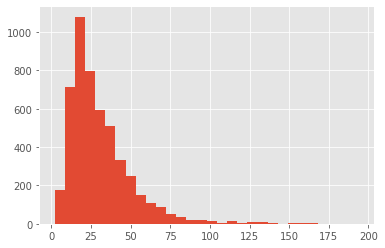

In [17]:
num_tokens = labeled_documents.text.apply(lambda x: len(x.split(" ")))
plt.hist(num_tokens, bins=30);

In [18]:
_set = set()
for __set in labeled_documents.text.apply(lambda x: set(x.split(" "))).values:
    _set = _set.union(__set)
print(f"Number of unique tokens: {len(_set)}")

Number of unique tokens: 17131


In [19]:
# load train/test hashes
#hash_docs_link = pd.read_json("./echo_span_labels/reduced_labels/merged_labels.jsonl", lines=True)[['text', '_input_hash']]
train_ids = pd.read_csv('./train_echoid.csv', sep=',').input_hash.unique()
test_ids = pd.read_csv('./test_echoid.csv', sep=',').input_hash.unique()

labeled_documents['_hash'] = labeled_documents.text.str.strip().apply(lambda x: hash(x))
#hash_docs_link['_hash'] = hash_docs_link.text.str.strip().apply(lambda x: hash(x))

#labeled_documents = labeled_documents.merge(hash_docs_link[['_input_hash', '_hash']], 
#                                            on='_hash', how='inner')

labeled_documents = labeled_documents.drop_duplicates(subset=['_hash']).reset_index(drop=True)

In [20]:
# Expand with label columns
if Class == 'merged_labels':
    Target_maps = {
        _Class: {Label:i for i,Label in enumerate(target_df[Class].unique())}
        for _Class in target_df.columns
    }
else:
    Target_maps = {
        Class: {Label: i for i,Label in enumerate(labeled_documents['label'].unique())} 
    }
    
if Class == 'merged_labels':
    DF = labeled_documents[['text', '_input_hash']].join(target_df[Class])
else:
    DF = labeled_documents[['text', '_input_hash', 'label']]

DF.columns = ['sentence', '_input_hash', 'labels']

label2id = Target_maps[Class]
id2label = {v:k for k,v in label2id.items()}
num_labels = len(label2id)

if use_multilabel:
    _multilabels = {label2id.get(k): [label2id.get(l) for l in v if label2id.get(l) is not None]
                    for k,v in MULTILABELS.items() if label2id.get(k) is not None}
else:
    _multilabels = None

DF= DF.assign(label=DF['labels'].map(label2id))

In [21]:
if use_multilabel:
    if all([len(v)==1 for v in _multilabels.values()]):
        use_multilabel = False
        _multilabels = None

## Clean text

In [22]:
DF = DF.assign(sentence=DF.sentence.str.replace(r'[\r\n]', '', regex=True)) 

In [23]:
if lemmatize:
    docs = nlp.pipe(DF.sentence.values)
    new_texts = [" ".join([token.lemma_ for token in doc]) for doc in docs] 
    DF = DF.assign(sentence = new_texts)

if lowercase:
    DF = DF.assign(sentence = DF.sentence.str.lower())
    
if filter_reports:
    DF = DF.assign(sentence = echo_utils.report_filter(DF.sentence, 
                                            flag_terms=FLAG_TERMS, 
                                            save_terms=SAVE_TERMS)[0])
    DF = DF.loc[DF.sentence.notna()]

if deabbreviate:
    DeAbber = deabber.deabber(model_type='sbert', abbreviations=ABBREVIATIONS['nl']['echocardiogram'], min_sim=0.5, top_k=10)
    DF = DF.assign(sentence=DeAbber.deabb(DF.sentence.values, TokenRadius=3))

# Make folds

In [24]:
# prepping
TrainTestDict = defaultdict(dict)

if Splitting == 'from_file':
    TrainTestDict[0]['Xtrain'] = DF.loc[DF._input_hash.isin(train_ids)].sentence
    TrainTestDict[0]['Xtest'] = DF.loc[DF._input_hash.isin(test_ids)].sentence
    
    TrainTestDict[0]['ytrain'] = DF.loc[DF._input_hash.isin(train_ids)].label
    TrainTestDict[0]['ytest'] = DF.loc[DF._input_hash.isin(test_ids)].label
    
elif Splitting == 'CV':
    for k,(train_index, test_index) in enumerate(fold_indices(targets=DF['label'], stratified=True)):
        TrainTestDict[k]['Xtrain'] = DF.iloc[train_index].sentence
        TrainTestDict[k]['Xtest'] = DF.iloc[test_index].sentence
        
        TrainTestDict[k]['ytrain'] = DF.iloc[train_index].label
        TrainTestDict[k]['ytest'] = DF.iloc[test_index].label
    

## Initiate models

In [25]:
if pre_trained_embeddings:
    TexToVec = echo_utils.TextToVectors(maxlen=max_len, 
                                        source=EmbeddingSource, 
                                        embedding_path=EmbeddingPath,
                                        use_progress_bar=False)
    pre_emb_dim = TexToVec.emb_dim
else:
    pre_emb_dim = None

In [35]:
ModelDict = defaultdict(dict)
for k,v in TrainTestDict.items():
    LSTM_Tokenizer = KerasTokenizer(num_words=num_words_in_vocab)
    if pre_trained_embeddings:
        vocab_size = num_words_in_vocab
    else:        
        LSTM_Tokenizer.fit_on_texts(v['Xtrain'])
        vocab_size = len(LSTM_Tokenizer.word_index)+1

    num_classes = np.unique(v['ytrain']).shape[0]
    
    ModelDict[k]['tokenizer'] = LSTM_Tokenizer    
    if use_multilabel:
        ModelDict[k]['warmup_model'] = echo_models.CurrentModel(modelselection=ModelType, 
                                     embeddingdim=embedding_dim,
                                     pre_embeddingdim = pre_emb_dim,
                                     maxlen=max_len,
                                     vocabsize=vocab_size,
                                     numclasses=num_classes,
                                     learningrate=LR,
                                     dilation=dilation,
                                     num_layers=num_layers,
                                     multilabel=False,
                                     pre_trained_vectors=pre_trained_embeddings,
                                     dropout=dropout
                                     )
    else:
        ModelDict[k]['model'] = echo_models.CurrentModel(modelselection=ModelType, 
                                     embeddingdim=embedding_dim,                                     
                                     pre_embeddingdim = pre_emb_dim,
                                     maxlen=max_len,
                                     vocabsize=vocab_size,
                                     numclasses=num_classes,
                                     learningrate=LR,
                                     dilation=dilation,
                                     num_layers=num_layers,
                                     multilabel=use_multilabel,
                                     pre_trained_vectors=pre_trained_embeddings,
                                     dropout=dropout
                                    )
    

## Warmup models

If we are running a multilabel classification with BCE loss we might get stuck in a local minimum where recall is 1 for all
classes. To avoid this we pre-run the model with categorical cross-entropy loss, with a softmax in the final layer. To be able to apply
the CCEloss we want 1 label per sample, we force by taking the minority class in each multilabel instance.

In [36]:
def make_multilabel(Model: Sequential, learningrate: float=1e-4) -> Sequential:
    """
    Make a multilabel classification model, given a pre-trained Sequential model.
    It replaces the last Dense layer with 'softmax' activation to a 'sigmoid' activation,
    making it suitable for multilabel classification.

    :param Model: A pre-trained Keras Sequential model.
    :return: A modified Sequential model ready for multilabel classification.
    """
    assert isinstance(Model, Sequential), "Model must be a Keras Sequential model."

    # Create a new Sequential model
    new_model = Sequential()

    # Copy all layers except the last one from the original model to the new model
    for layer in Model.layers[:-1]:
        new_model.add(layer)

    # Assume the last layer is a Dense layer and get the number of units from it
    num_classes = Model.layers[-1].output_shape[-1]

    # Add a new Dense layer with sigmoid activation suited for multilabel classification
    new_model.add(layers.Dense(num_classes, activation='sigmoid'))

    # Important: this line copies the weights of all layers except the last one from the original model
    for layer, new_layer in zip(Model.layers[:-1], new_model.layers[:-1]):
        new_layer.set_weights(layer.get_weights())

    new_model.compile(optimizer = optimizers.Adam(learning_rate=learningrate),
                      loss = 'binary_crossentropy',
                      metrics = ['binary_accuracy'])
    
    return new_model


# def make_multilabel(model: Sequential):
#     '''
#     Make a multilabel classification model, given a pre-trained Sequential model.
#     Actions:
#      1. Replace layers.Dense(numclasses, activation = 'softmax') with
#         layers.Dense(numclasses, activation = 'sigmoid')
#      2. Replace the loss function 'categorical_crossentropy' with 'binary_crossentropy'.
# 
#     :param model: A pre-trained Keras Sequential model.
#     :return: Sequential model with pretrained weights, adapted for multi-label classification.
#     '''
# 
#     assert isinstance(model, Sequential), "Multilabel model must be Sequential"
# 
#     # Modify the output layer
#     for layer in model.layers:
#         if isinstance(layer, Dense) and layer.activation == tf.keras.activations.softmax:
#             num_classes = layer.units  # Preserve number of classes
#             model.pop()  # Remove old output layer
#             model.add(Dense(num_classes, activation='sigmoid'))
#             break  # Assuming only one softmax output layer
# 
#     # Replace loss function (assuming 'categorical_crossentropy' was used originally)
#     model.compile(optimizer=model.optimizer,  # Preserve the optimizer
#                   loss='binary_crossentropy', 
#                   metrics=['accuracy'])  # Or other suitable metrics
# 
#     return model

In [37]:
WarmupDict = defaultdict(lambda: defaultdict(list))
if use_multilabel:   
    # run with softmax and CCEloss
    for k,v in ModelDict.items():
        _model =  v['warmup_model']
        _tokenizer = v['tokenizer']
        
        if pre_trained_embeddings:
            X_train = TexToVec.text_to_vectors(TrainTestDict[k]['Xtrain']) 
            X_test = TexToVec.text_to_vectors(TrainTestDict[k]['Xtest']) 
        else:
            X_train = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtrain'])
            X_test = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtest'])
        
            X_train = pad_sequences(X_train, padding = 'post', maxlen=max_len)
            X_test = pad_sequences(X_test, padding = 'post', maxlen=max_len)
    
        _y = TrainTestDict[k]['ytrain']
        y_train = multi_hot_encoding(_y, multilabels=None, num_classes=num_labels) # keras_utils.to_categorical(_y)
    
        _y = TrainTestDict[k]['ytest']
        y_test = multi_hot_encoding(_y, multilabels=None, num_classes=num_labels) # keras_utils.to_categorical(_y)
    
        if UseClassWeights:
            PosSum = 1/np.sum(y_train, axis=0)
            ClassWeights = dict(enumerate(PosSum/np.min(PosSum)))
        else:
            ClassWeights = None
        
        result_list = []
        history_list = []
        confusion_list = []
        for epoch_num in range(1, warmup_steps+1):
            _history = _model.fit(X_train,
                                 y_train,                         
                                 epochs = 1,
                                 verbose = False,
                                 validation_split = 0,
                                 class_weight=ClassWeights,
                                 batch_size = batch_size)
        
            y_pred = _model.predict(X_test, verbose=False)
            _res = multi_label_metrics(labels=y_test, probs=y_pred)
            
            result_list.append(_res)
            history_list.append({'loss': _history.history['loss'][0], 
                                 'accuracy': _history.history['binary_accuracy'][0]})
            confusion_list.append(confusion_matrix(np.argmax(y_test, axis=1),
                                                   np.argmax(np.round(y_pred),axis=1),  normalize='true'))
            
            
            print(f"Epoch {epoch_num}, F1 Macro={_res['f1_macro']}")
            
        WarmupDict[k]['history'] = pd.DataFrame(history_list)
        WarmupDict[k]['result'] = pd.DataFrame(result_list)
        WarmupDict[k]['confusion'] = confusion_list
        
        ModelDict[k]['model'] = make_multilabel(_model, learningrate=warmup_lr)
         
    

In [38]:
id2label

{0: 'Normal', 1: 'Mild', 2: 'No label', 3: 'Moderate', 4: 'Severe'}

# Train

In [39]:
if use_multilabel:
    _confusion_matrix = multilabel_confusion_matrix
else:
    _confusion_matrix = confusion_matrix

In [41]:
ResultDict = defaultdict(lambda: defaultdict(list))
for k,v in ModelDict.items():
    _model =  v['model']
    _tokenizer = v['tokenizer']
    
    if pre_trained_embeddings:
        X_train_pre = TexToVec.text_to_vectors(TrainTestDict[k]['Xtrain']) 
        X_test_pre = TexToVec.text_to_vectors(TrainTestDict[k]['Xtest']) 
        
        X_train = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtrain'])
        X_test = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtest'])
    
        X_train = pad_sequences(X_train, padding = 'post', maxlen=max_len)
        X_test = pad_sequences(X_test, padding = 'post', maxlen=max_len)
        
        X_train = [X_train, X_train_pre]
        X_test = [X_test, X_test_pre]
    else:
        X_train = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtrain'])
        X_test = _tokenizer.texts_to_sequences(TrainTestDict[k]['Xtest'])
    
        X_train = pad_sequences(X_train, padding = 'post', maxlen=max_len)
        X_test = pad_sequences(X_test, padding = 'post', maxlen=max_len)

    _y = TrainTestDict[k]['ytrain']
    y_train = multi_hot_encoding(_y, multilabels=_multilabels, num_classes=num_labels) # keras_utils.to_categorical(_y)

    _y = TrainTestDict[k]['ytest']
    y_test = multi_hot_encoding(_y, multilabels=_multilabels, num_classes=num_labels) # keras_utils.to_categorical(_y)

    if UseClassWeights:
        PosSum = 1/np.sum(y_train, axis=0)
        ClassWeights = dict(enumerate(PosSum/np.min(PosSum)))
    else:
        ClassWeights = None
    
    result_list = []
    history_list = []
    confusion_list = []
    for epoch_num in range(1, num_epochs+1):
        _history = _model.fit(X_train,
                             y_train,                         
                             epochs = 1,
                             verbose = False,
                             validation_split = 0,
                             class_weight=ClassWeights,
                             batch_size = batch_size)
    
        y_pred = _model.predict(X_test, verbose=False)
        _res = multi_label_metrics(labels=y_test, probs=y_pred)
        
        result_list.append(_res)
        history_list.append({'loss': _history.history['loss'][0], 
                             'accuracy': _history.history['binary_accuracy'][0]})
        confusion_list.append(_confusion_matrix(np.argmax(y_test, axis=1),
                                               np.argmax(np.round(y_pred),axis=1)))
        
        
        print(f"Epoch {epoch_num}, F1 Macro={_res['f1_macro']}")
        
    ResultDict[k]['history'] = pd.DataFrame(history_list)
    ResultDict[k]['result'] = pd.DataFrame(result_list)
    ResultDict[k]['confusion'] = confusion_list
    

d:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\VENVS\Envs\nlp_310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, F1 Macro=0.3481444384783776
Epoch 2, F1 Macro=0.7780002383686982
Epoch 3, F1 Macro=0.8705132904729679
Epoch 4, F1 Macro=0.8763159980187689
Epoch 5, F1 Macro=0.874305098095592
Epoch 6, F1 Macro=0.8879734761403852
Epoch 7, F1 Macro=0.88630759927645
Epoch 8, F1 Macro=0.8876851700159957
Epoch 9, F1 Macro=0.8902460252350684
Epoch 10, F1 Macro=0.893833973283443
Epoch 11, F1 Macro=0.8879850545207152
Epoch 12, F1 Macro=0.8952278190714804
Epoch 13, F1 Macro=0.8950809901530331
Epoch 14, F1 Macro=0.904092235061406
Epoch 15, F1 Macro=0.8962985288690882
Epoch 16, F1 Macro=0.88093724626256
Epoch 17, F1 Macro=0.8894006101874865
Epoch 18, F1 Macro=0.8880876154259143
Epoch 19, F1 Macro=0.8919328230156147
Epoch 20, F1 Macro=0.8895845310352388


In [42]:
confusion_list[-1]

array([[551,   6,  11,   1,   1],
       [  2, 167,   1,  11,   0],
       [  9,   3,  88,   0,   0],
       [  2,   1,   4,  53,   3],
       [  0,   0,   4,   5,  58]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

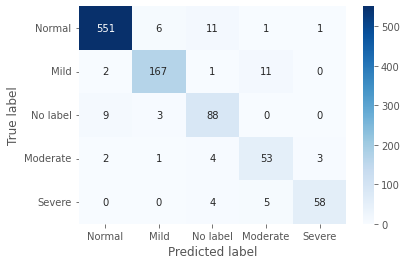

In [43]:
heatmap_df = \
    pd.DataFrame(
    confusion_list[-1],
        columns=label2id.keys(),
        index=label2id.keys()
    )
sns.heatmap(heatmap_df.round(4), annot=True, cmap='Blues', fmt='g')
    # df.style.background_gradient(cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [44]:
print(f"Class: {Class}, Model: {ModelType}, Splitting: {Splitting}")

Class: lv_syst_func, Model: vstacked_dcnn, Splitting: from_file


In [45]:
MultiLabelStr = 'multilabel' if use_multilabel else 'categorical'
PretrainStr = 'pretrainedEmbs' if pre_trained_embeddings else ""
ResultDict[k]['result'].to_csv(f"../../G_Output/2_Data/results_{MultiLabelStr}_{Class}_{ModelType}_{PretrainStr}_{Splitting}.csv", sep=";")

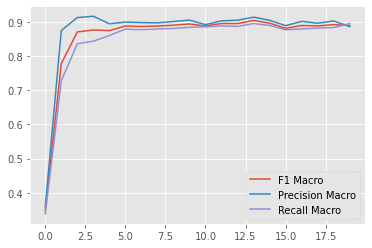

In [46]:
plt.plot(ResultDict[k]['result']['f1_macro'], label='F1 Macro')
plt.plot(ResultDict[k]['result']['prec_macro'], label='Precision Macro')
plt.plot(ResultDict[k]['result']['recall_macro'], label='Recall Macro')
plt.legend(loc='best')
plt.show()

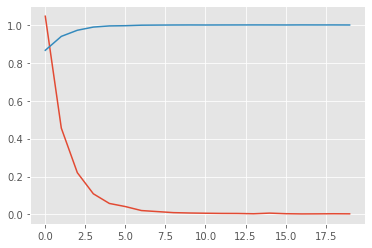

In [47]:
plt.plot(ResultDict[k]['history'])

In [48]:
ResultDict[k]['result'].sort_values(by='f1_macro', ascending=False).head(1)

,f1_macro,f1_weighted,prec_macro,prec_weighted,recall_macro,recall_weighted,roc_auc_macro,roc_auc_weighted,accuracy
13,0.904092,0.943805,0.913706,0.947092,0.895134,0.940877,0.989956,0.992142,0.940877


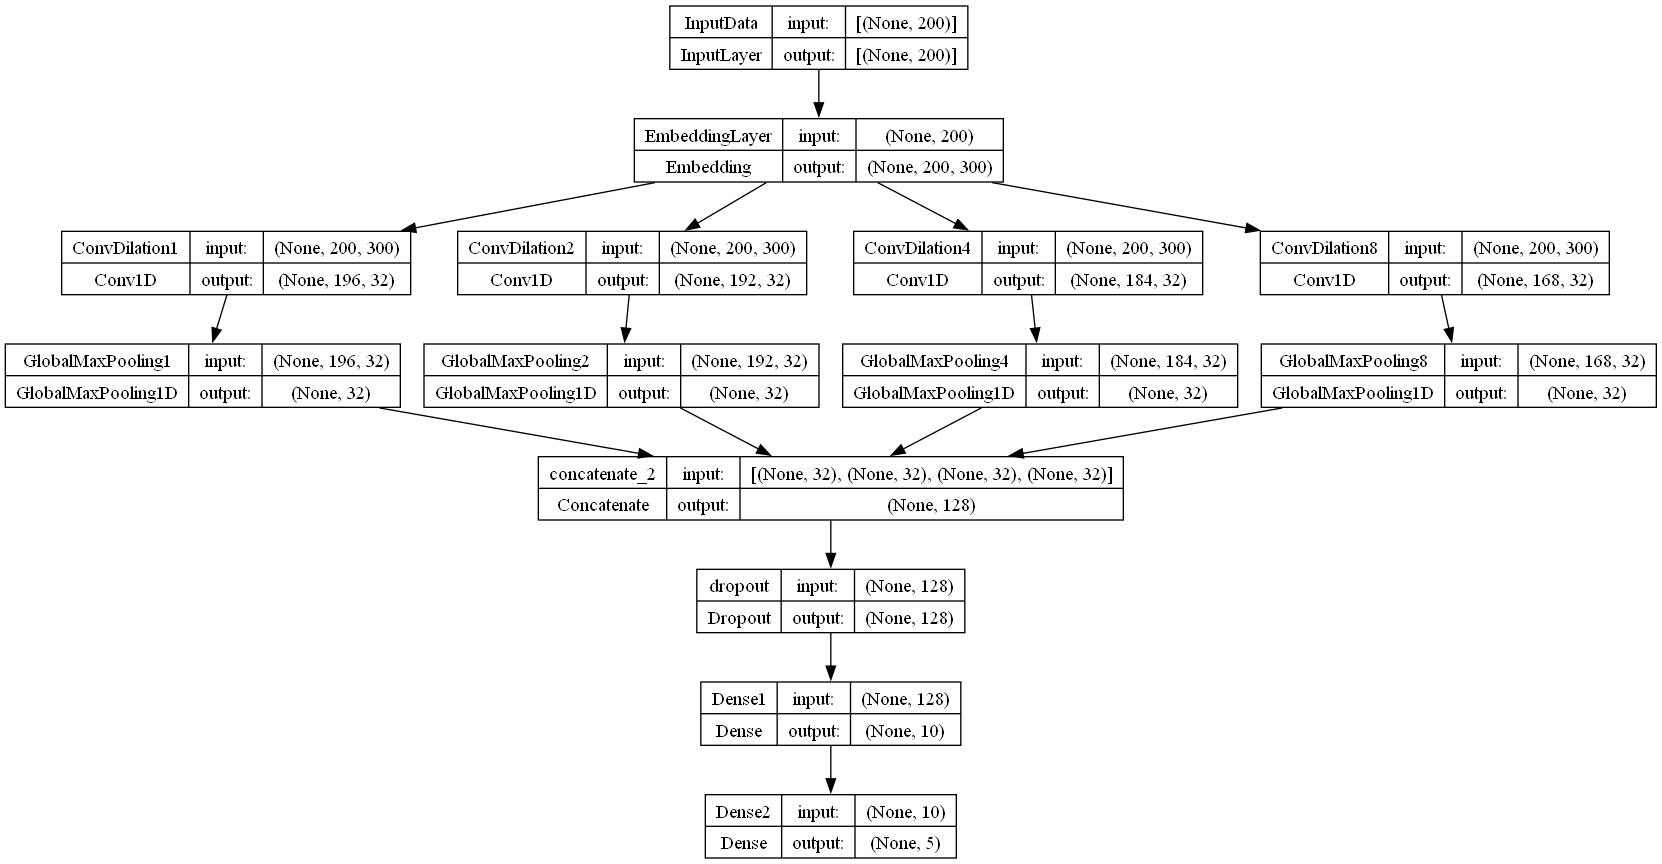

In [49]:
plot_model(_model, to_file='./model_plot.png', show_shapes=True, show_layer_names=True)

## Upload to huggingface hub